# Main

In [1]:
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import numpy as np
import functools as funct
import itertools as itert
import collections as coll

In [2]:
import pandas as pd
geo = pd.read_csv('geo_params.csv')
geo

,geoCluster,cityId
0,21,1
1,47,1
2,48,1
3,92,1
4,112,1
...,...,...
510,3182,0
511,3183,0
512,3196,0
513,3209,0


In [3]:
geo.groupby(by=['cityId']).unique()

AttributeError: 'DataFrameGroupBy' object has no attribute 'unique'

In [4]:
sales = pd.read_csv('sales.csv')
sales.head()

,ID,geoCluster,SKU,date,price,sales
0,RR27956459,92,32485,2021-07-05,38.29,4.0
1,RR27956474,92,32549,2021-07-05,89.39,0.5
2,RR27956489,112,32485,2021-05-27,45.39,3.7
3,RR27956490,112,32485,2021-05-28,NaN,NaN
4,RR27956491,112,32485,2021-05-29,NaN,NaN


In [5]:
sales.isna().sum() / sales.shape[0]

ID            0.00000
geoCluster    0.00000
SKU           0.00000
date          0.00000
price         0.83101
sales         0.83101
dtype: float64

In [6]:
sku = pd.read_csv('sku.csv')
sku.head()

,SKU,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group
0,24,Pomegranate,Tropical fruit — Pomegranate— Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits
1,208,"Water, sparkling",Therapeutic-table water — PET — from 1 to 2 L,1241.0,1.5,NaN,3670.0,1.0,Mineral water
2,1008,"Water, import, sparkling",Therapeutic-table water — Import — Glass,1241.0,0.5,NaN,4970.0,14.0,Mineral water
3,16649,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water
4,20872,"Water, sparkling",Therapeutic-table water — PET — from 1 to 2 L,2693.0,1.5,NaN,4384.0,1.0,Mineral water


# Merge

In [7]:
merge = sales.merge(sku, how='inner', left_on='SKU', right_on='SKU')
merge = merge.merge(geo, how='inner', left_on='geoCluster', right_on='geoCluster')
merge

,ID,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group,cityId
0,RR27956459,92,32485,2021-07-05,38.29,4.0,Banana,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
1,RR27956474,92,32549,2021-07-05,89.39,0.5,Grapefruit,Citrus fruit — Grapefruit — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
2,RR42800188,92,16649,2021-06-05,17.69,1.0,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,1
3,RR42800189,92,16649,2021-06-06,NaN,NaN,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,1
4,RR42800190,92,16649,2021-06-07,NaN,NaN,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605980,RR50600743,162,503007,2021-07-01,NaN,NaN,"Plain rye-wheat bread, parbaking",Bread — plain — rye-wheat,8274.0,340.0,NaN,NaN,1.0,Bakery,1
4605981,RR50600744,162,503007,2021-07-02,NaN,NaN,"Plain rye-wheat bread, parbaking",Bread — plain — rye-wheat,8274.0,340.0,NaN,NaN,1.0,Bakery,1
4605982,RR50600745,162,503007,2021-07-03,NaN,NaN,"Plain rye-wheat bread, parbaking",Bread — plain — rye-wheat,8274.0,340.0,NaN,NaN,1.0,Bakery,1
4605983,RR50600746,162,503007,2021-07-04,NaN,NaN,"Plain rye-wheat bread, parbaking",Bread — plain — rye-wheat,8274.0,340.0,NaN,NaN,1.0,Bakery,1


In [8]:
merge = merge[~merge['sales'].isna()]
merge.head()

,ID,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group,cityId
0,RR27956459,92,32485,2021-07-05,38.29,4.0,Banana,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
1,RR27956474,92,32549,2021-07-05,89.39,0.5,Grapefruit,Citrus fruit — Grapefruit — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
2,RR42800188,92,16649,2021-06-05,17.69,1.0,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,1
33,RR42800233,92,440815,2021-07-02,45.79,2.0,"Water, still",Table water — PET — more than 3 L,1330.0,6.0,NaN,2781.0,1.0,Mineral water,1
36,RR42800236,92,440815,2021-07-05,45.79,1.0,"Water, still",Table water — PET — more than 3 L,1330.0,6.0,NaN,2781.0,1.0,Mineral water,1


In [9]:
merge['date'] = pd.to_datetime(merge.date).copy()

/tmp/ipykernel_48306/2336709110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge['date'] = pd.to_datetime(merge.date).copy()


In [10]:
merge

,ID,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group,cityId
0,RR27956459,92,32485,2021-07-05,38.29,4.0,Banana,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
1,RR27956474,92,32549,2021-07-05,89.39,0.5,Grapefruit,Citrus fruit — Grapefruit — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,1
2,RR42800188,92,16649,2021-06-05,17.69,1.0,"Water, still",Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,1
33,RR42800233,92,440815,2021-07-02,45.79,2.0,"Water, still",Table water — PET — more than 3 L,1330.0,6.0,NaN,2781.0,1.0,Mineral water,1
36,RR42800236,92,440815,2021-07-05,45.79,1.0,"Water, still",Table water — PET — more than 3 L,1330.0,6.0,NaN,2781.0,1.0,Mineral water,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4604927,RR55832871,2963,437495,2020-11-29,19.99,4.0,"Plain croissant, parbaking",Croissant,8314.0,50.0,NaN,9666.0,6.0,Bakery,0
4605146,RR42809513,1315,20872,2021-06-08,34.89,2.0,"Water, sparkling",Therapeutic-table water — PET — from 1 to 2 L,2693.0,1.5,NaN,4384.0,1.0,Mineral water,0
4605174,RR42815378,1790,233272,2020-12-23,29.09,4.0,"Water, import, sparkling",Therapeutic-table water — Import — PET,2737.0,1.0,NaN,1839.0,14.0,Mineral water,0
4605921,RR50628992,1629,690818,2021-05-15,25.49,4.0,"Ciabatta, light, plain, parbaking",Ciabatta,8274.0,250.0,NaN,4043.0,NaN,Bakery,0


In [11]:
len(merge['Group'].unique())

5

In [12]:
import seaborn as sns
from IPython.display import display

# Fourirer

<AxesSubplot:xlabel='date', ylabel='sales'>

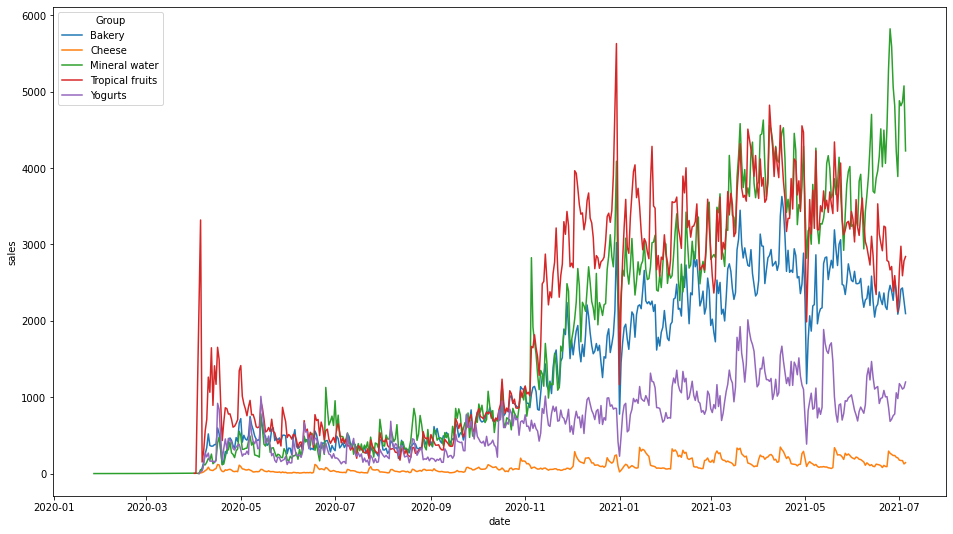

Timedelta('460 days 00:00:00')

Timedelta('525 days 00:00:00')

Timedelta('457 days 00:00:00')

Timedelta('457 days 00:00:00')

Timedelta('457 days 00:00:00')

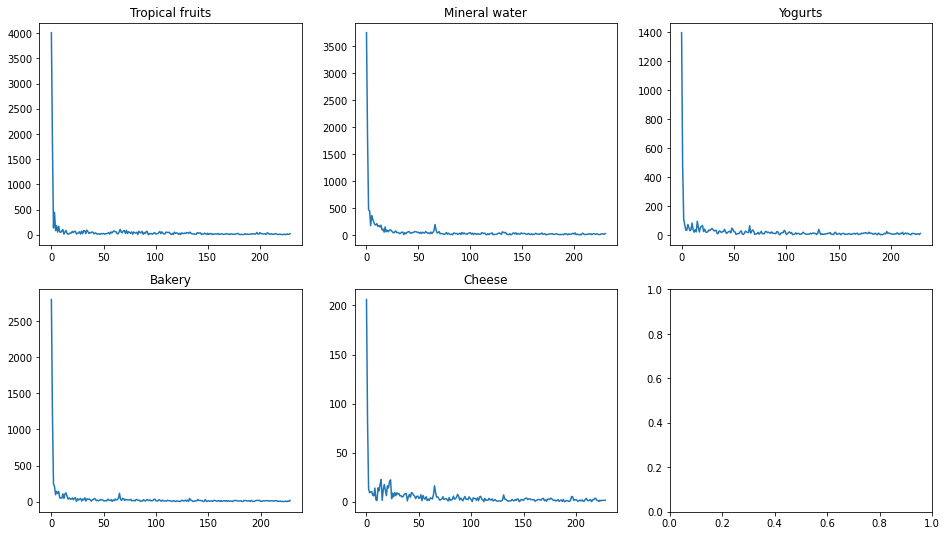

In [13]:
def get_groups(df):
    df = df.groupby(by=['Group', 'date']).sum()
    return df

groups = merge['Group'].unique()
df= get_groups(merge)
fig = plt.figure(figsize=(16, 9))
display(sns.lineplot(data=df, x='date', y='sales', hue='Group'))
plt.show()
fig, axes = plt.subplots(2,3, figsize=(16, 9))
axes = list(axes[0]) + list(axes[1])
for ax, g in zip(axes, groups):
    df_group = df.loc[g]
    sales = df_group['sales']
    timedelta = df_group.index.max() - df_group.index.min()
    display(timedelta)
    N = sales.shape[0]
    yf = fft(np.array(sales))
    xf = fftfreq(N, 1/N)[:N//2]
    sns.lineplot(x=xf, y=2.0/N * np.abs(yf[0:N//2]), ax=ax)
    ax.set_title(g)


<AxesSubplot:xlabel='date', ylabel='sales'>

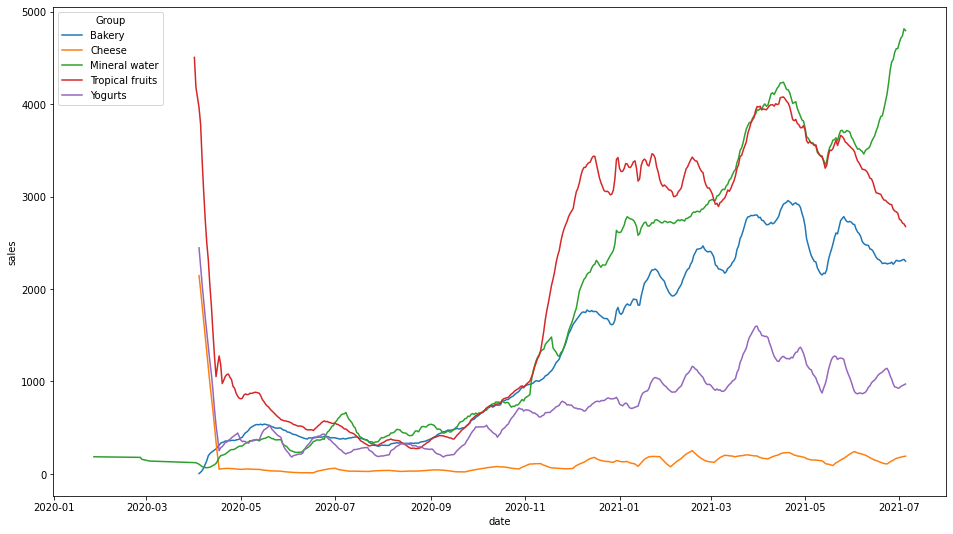

In [14]:
plt.figure(figsize=(16, 9))
display(sns.lineplot(data=df.rolling(14, min_periods=1).mean(), x='date', y='sales', hue='Group'))

In [15]:
x_fields = ['price']
y_field = ['sales']
df = get_groups(merge)
df = df[x_fields + y_field]
df.describe()

,price,sales
count,2297.000000,2297.000000
mean,22870.021720,1217.784541
std,24026.310011,1265.606559
min,18.490000,1.000000
25%,5890.490000,253.000000
50%,14456.170000,660.300000
75%,29875.400000,2206.900000
max,126219.650000,5821.000000


In [16]:
df

price   sales
Group   date                        
Bakery  2020-04-04    100.98     3.7
        2020-04-05    431.26    31.2
        2020-04-06   1046.97    71.9
        2020-04-07   2501.54   150.0
        2020-04-08   4004.21   257.4
...                      ...     ...
Yogurts 2021-07-01  17333.07  1178.0
        2021-07-02  17005.42  1148.0
        2021-07-03  17226.07  1106.0
        2021-07-04  16737.00  1123.0
        2021-07-05  17557.90  1199.0

[2297 rows x 2 columns]

In [18]:
df.to_pickle('clean.pickle')

In [275]:
df['new_sales'] = df.groupby(level=0)['sales'].shift(-1)
new_df = df.loc['Bakery'].reset_index(drop=True)
new_df

,price,sales,new_sales
0,100.98,3.7,31.2
1,431.26,31.2,71.9
2,1046.97,71.9,150.0
3,2501.54,150.0,257.4
4,4004.21,257.4,342.2
...,...,...,...
453,27329.81,2192.3,2413.6
454,26777.24,2413.6,2430.1
455,27875.36,2430.1,2266.2
456,27940.34,2266.2,2094.4


In [278]:
new_df.iloc(axis=1)[:-1], new_df.iloc(axis=1)[-1]

(        price   sales
 0      100.98     3.7
 1      431.26    31.2
 2     1046.97    71.9
 3     2501.54   150.0
 4     4004.21   257.4
 ..        ...     ...
 453  27329.81  2192.3
 454  26777.24  2413.6
 455  27875.36  2430.1
 456  27940.34  2266.2
 457  25693.39  2094.4
 
 [458 rows x 2 columns],
 0        31.2
 1        71.9
 2       150.0
 3       257.4
 4       342.2
         ...  
 453    2413.6
 454    2430.1
 455    2266.2
 456    2094.4
 457       NaN
 Name: new_sales, Length: 458, dtype: float64)

In [265]:
res = []
display(df)
for g in groups:

pd.concat(res)

price  sales
Group   date                      
Bakery  2020-04-04   100.98    3.7
        2020-04-05   431.26   31.2
        2020-04-06  1046.97   71.9
        2020-04-07  2501.54  150.0
        2020-04-08  4004.21  257.4
...                     ...    ...
Yogurts 2021-07-01  2610.69  252.0
        2021-07-02  2483.89  327.0
        2021-07-03  2648.75  325.0
        2021-07-04  2930.25  320.0
        2021-07-05  3464.10  370.0

[2297 rows x 2 columns]

'Tropical fruits'

,price,sales
date,,
2020-04-01,79.59,4.000
2020-04-02,121.68,4.400
2020-04-04,4120.19,2234.650
2020-04-05,6705.54,3319.210
2020-04-06,4523.91,152.100
...,...,...
2021-07-01,49622.05,2648.857
2021-07-02,50887.97,2975.830
2021-07-03,55462.89,2589.350


/tmp/ipykernel_22124/4091515047.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



price  sales  new_sales
Group   date                                 
Bakery  2020-04-04   100.98    3.7        NaN
        2020-04-05   431.26   31.2        NaN
        2020-04-06  1046.97   71.9        NaN
        2020-04-07  2501.54  150.0        NaN
        2020-04-08  4004.21  257.4        NaN
...                     ...    ...        ...
Yogurts 2021-06-30  3163.77  372.0        NaN
        2021-07-01  2610.69  252.0        NaN
        2021-07-02  2483.89  327.0        NaN
        2021-07-03  2648.75  325.0        NaN
        2021-07-04  2930.25  320.0        NaN

[2296 rows x 3 columns]

'Mineral water'

,price,sales
date,,
2020-01-27,40.59,1.0
2020-02-26,32.79,2.0
2020-02-27,32.79,2.0
2020-03-03,36.89,2.0
2020-04-02,71.58,6.0
...,...,...
2021-07-01,17322.11,4880.0
2021-07-02,18093.31,4814.0
2021-07-03,19020.59,4861.0


/tmp/ipykernel_22124/4091515047.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



price  sales  new_sales
Group   date                                 
Bakery  2020-04-04   100.98    3.7        NaN
        2020-04-05   431.26   31.2        NaN
        2020-04-06  1046.97   71.9        NaN
        2020-04-07  2501.54  150.0        NaN
        2020-04-08  4004.21  257.4        NaN
...                     ...    ...        ...
Yogurts 2021-06-30  3163.77  372.0        NaN
        2021-07-01  2610.69  252.0        NaN
        2021-07-02  2483.89  327.0        NaN
        2021-07-03  2648.75  325.0        NaN
        2021-07-04  2930.25  320.0        NaN

[2296 rows x 3 columns]

'Yogurts'

,price,sales
date,,
2020-04-04,18.49,3.0
2020-04-05,77.16,17.0
2020-04-06,172.81,20.0
2020-04-07,428.40,56.0
2020-04-08,892.98,150.0
...,...,...
2021-07-01,2610.69,252.0
2021-07-02,2483.89,327.0
2021-07-03,2648.75,325.0


/tmp/ipykernel_22124/4091515047.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



price  sales  new_sales
Group   date                                 
Bakery  2020-04-04   100.98    3.7        NaN
        2020-04-05   431.26   31.2        NaN
        2020-04-06  1046.97   71.9        NaN
        2020-04-07  2501.54  150.0        NaN
        2020-04-08  4004.21  257.4        NaN
...                     ...    ...        ...
Yogurts 2021-06-30  3163.77  372.0        NaN
        2021-07-01  2610.69  252.0        NaN
        2021-07-02  2483.89  327.0        NaN
        2021-07-03  2648.75  325.0        NaN
        2021-07-04  2930.25  320.0        NaN

[2296 rows x 3 columns]

'Bakery'

,price,sales
date,,
2020-04-04,100.98,3.7
2020-04-05,431.26,31.2
2020-04-06,1046.97,71.9
2020-04-07,2501.54,150.0
2020-04-08,4004.21,257.4
...,...,...
2021-07-01,27329.81,2192.3
2021-07-02,26777.24,2413.6
2021-07-03,27875.36,2430.1


/tmp/ipykernel_22124/4091515047.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



price  sales  new_sales
Group   date                                 
Bakery  2020-04-04   100.98    3.7        NaN
        2020-04-05   431.26   31.2        NaN
        2020-04-06  1046.97   71.9        NaN
        2020-04-07  2501.54  150.0        NaN
        2020-04-08  4004.21  257.4        NaN
...                     ...    ...        ...
Yogurts 2021-06-30  3163.77  372.0        NaN
        2021-07-01  2610.69  252.0        NaN
        2021-07-02  2483.89  327.0        NaN
        2021-07-03  2648.75  325.0        NaN
        2021-07-04  2930.25  320.0        NaN

[2296 rows x 3 columns]

'Cheese'

,price,sales
date,,
2020-04-04,851.97,3.20
2020-04-05,2930.19,9.40
2020-04-06,6381.27,13.50
2020-04-07,10433.70,23.20
2020-04-08,16743.94,39.40
...,...,...
2021-07-01,93873.27,177.00
2021-07-02,89073.80,171.90
2021-07-03,88299.41,171.13


/tmp/ipykernel_22124/4091515047.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



price  sales  new_sales
Group   date                                 
Bakery  2020-04-04   100.98    3.7        NaN
        2020-04-05   431.26   31.2        NaN
        2020-04-06  1046.97   71.9        NaN
        2020-04-07  2501.54  150.0        NaN
        2020-04-08  4004.21  257.4        NaN
...                     ...    ...        ...
Yogurts 2021-06-30  3163.77  372.0        NaN
        2021-07-01  2610.69  252.0        NaN
        2021-07-02  2483.89  327.0        NaN
        2021-07-03  2648.75  325.0        NaN
        2021-07-04  2930.25  320.0        NaN

[2296 rows x 3 columns]

price  sales  new_sales
Group   date                                 
Bakery  2020-04-04   100.98    3.7        NaN
        2020-04-05   431.26   31.2        NaN
        2020-04-06  1046.97   71.9        NaN
        2020-04-07  2501.54  150.0        NaN
        2020-04-08  4004.21  257.4        NaN
...                     ...    ...        ...
Yogurts 2021-06-30  3163.77  372.0        NaN
        2021-07-01  2610.69  252.0        NaN
        2021-07-02  2483.89  327.0        NaN
        2021-07-03  2648.75  325.0        NaN
        2021-07-04  2930.25  320.0        NaN

[11480 rows x 3 columns]

In [238]:
df.to_csv('clean.csv')

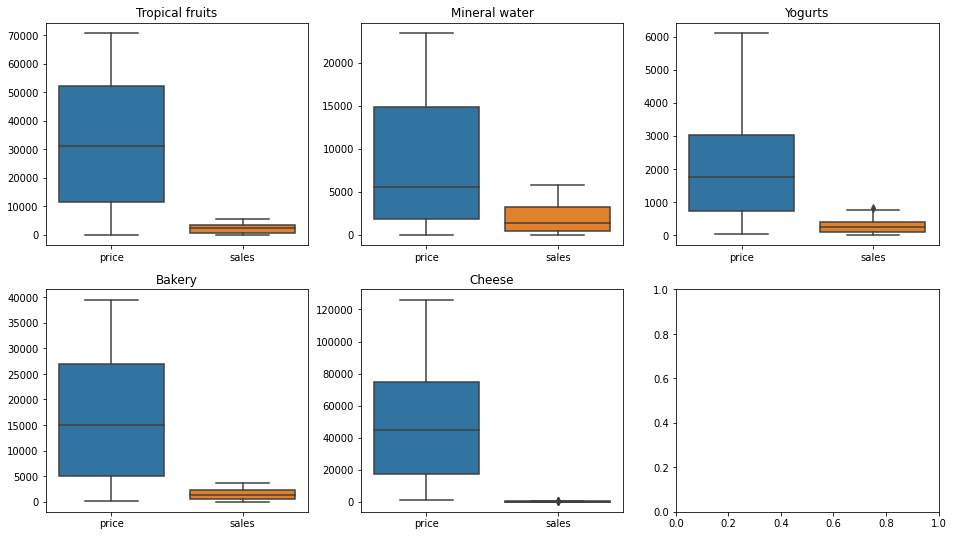

In [194]:
def ho_plot_group(df, func):
    fig, axes = plt.subplots(2,3, figsize=(16, 9))
    axes = list(axes[0]) + list(axes[1])
    for ax, g in zip(axes, groups):
        df_tmp = df.loc[g]
        func(df_tmp, ax)
        ax.set_title(g)

ho_plot_group(df, lambda x, ax: sns.boxplot(data=x, ax=ax))

# ARIMA

In [213]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

date
2020-04-01       0.000000
2020-04-02       3.955978
2020-04-04       4.210925
2020-04-05    1985.689267
2020-04-06    2413.351941
                 ...     
2021-05-03    2681.339318
2021-05-04    3489.197051
2021-05-05    3792.812097
2021-05-06    3183.824873
2021-05-07    3605.181715
Name: predicted_mean, Length: 401, dtype: float64

/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

date
2020-01-27       0.000000
2020-02-26       0.986924
2020-02-27       1.838816
2020-03-03       1.721374
2020-04-02       1.718913
                 ...     
2021-04-30    3819.345639
2021-05-01    4096.556839
2021-05-02    3494.531799
2021-05-03    3137.543891
2021-05-04    3468.850785
Name: predicted_mean, Length: 401, dtype: float64

/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2020-04-04      0.000000
2020-04-05      2.996885
2020-04-06     13.829281
2020-04-07     17.581589
2020-04-08     43.952044
                 ...    
2021-05-05    425.023150
2021-05-06    445.044822
2021-05-07    371.849531
2021-05-08    432.638149
2021-05-09    484.464395
Freq: D, Name: predicted_mean, Length: 401, dtype: float64

/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2020-04-04       0.000000
2020-04-05       3.687425
2020-04-06      29.155519
2020-04-07      61.196203
2020-04-08     119.072327
                 ...     
2021-05-05    2166.563939
2021-05-06    1818.705760
2021-05-07    1996.729633
2021-05-08    1967.330383
2021-05-09    2516.648107
Freq: D, Name: predicted_mean, Length: 401, dtype: float64

/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ori/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2020-04-04      0.000000
2020-04-05      3.199566
2020-04-06      8.885902
2020-04-07     12.627848
2020-04-08     21.410575
                 ...    
2021-05-05    171.095626
2021-05-06    156.720446
2021-05-07    149.036354
2021-05-08    133.877092
2021-05-09    145.266563
Freq: D, Name: predicted_mean, Length: 401, dtype: float64

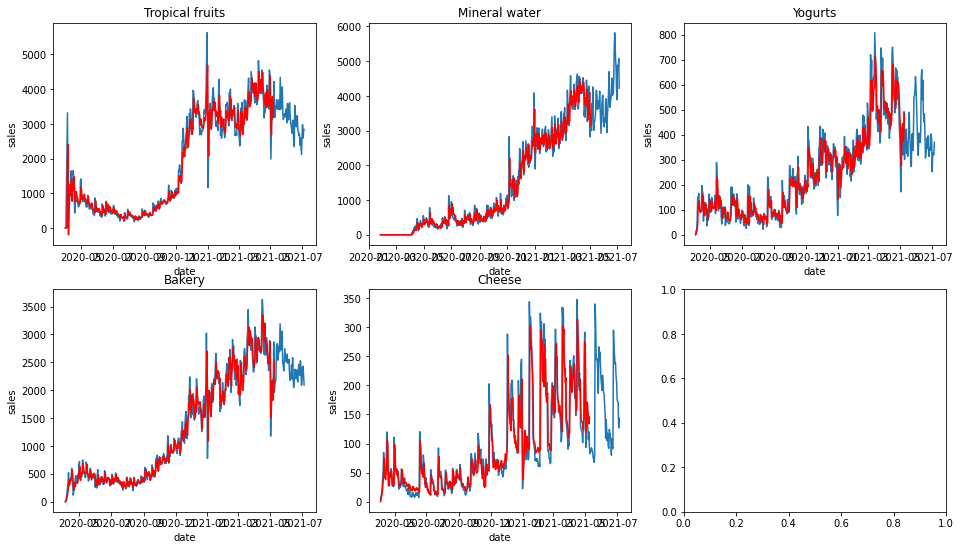

In [220]:
def arima_plot(df, ax):
    sns.lineplot(data=df, x='date', y='sales', ax=ax)
    model = ARIMA(df['sales'], order=(2,1,2))
    model_fit = model.fit()
    res = model_fit.predict(start=0, end=400)
    display(res)
    ax.plot(res, color="red")
ho_plot_group(df,arima_plot)

In [90]:
merge.groupby(by='Category').agg(['value_counts'])

StopIteration: 

In [85]:
merge.groupby(by='countryOfOrigin')


,ID,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,Units,trademark,Group,cityId
countryOfOrigin,,,,,,,,,,,,,,
1.0,278512,278512,278512,278512,278512,278512,278512,278512,151204,278512,0,268975,278512,278512
6.0,18041,18041,18041,18041,18041,18041,18041,18041,18041,18041,0,18041,18041,18041
14.0,32756,32756,32756,32756,32756,32756,32756,32756,32756,32756,0,32756,32756,32756
16.0,31929,31929,31929,31929,31929,31929,31929,31929,31929,31929,0,31929,31929,31929
33.0,17082,17082,17082,17082,17082,17082,17082,17082,17082,17082,0,17082,17082,17082
37.0,7461,7461,7461,7461,7461,7461,7461,7461,0,7461,0,0,7461,7461


In [87]:
merge.isna().sum() / merge.shape[0]

ID                   0.000000
geoCluster           0.000000
SKU                  0.000000
date                 0.000000
price                0.000000
sales                0.000000
Category             0.000000
Type                 0.000000
brandId              0.555274
lagerUnitQuantity    0.000000
Units                1.000000
trademark            0.308907
countryOfOrigin      0.464953
Group                0.000000
cityId               0.000000
dtype: float64

In [83]:
merge.describe()

,geoCluster,SKU,price,sales,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,cityId
count,721023.000000,721023.000000,721023.000000,721023.000000,320658.000000,721023.000000,0.0,498294.000000,385781.000000,721023.000000
mean,2230.320496,281627.401929,68.286437,3.603115,3193.694762,88.360915,NaN,7090.747183,5.692268,0.000411
std,268.906156,275970.443163,88.888607,4.752627,2510.249840,149.439446,NaN,4824.627030,9.084592,0.035249
min,92.000000,24.000000,0.000000,0.001000,1241.000000,0.500000,NaN,297.000000,1.000000,0.000000
25%,2041.000000,32546.000000,22.490000,1.000000,1241.000000,1.000000,NaN,2781.000000,1.000000,0.000000
50%,2131.000000,144184.000000,36.990000,2.300000,2737.000000,1.500000,NaN,8802.000000,1.000000,0.000000
75%,2279.000000,552806.000000,56.890000,4.000000,2737.000000,120.000000,NaN,9666.000000,6.000000,0.000000
max,3230.000000,838137.000000,7246.890000,801.000000,8314.000000,550.000000,NaN,15156.000000,37.000000,25.000000


In [84]:
merge.sort_values('sales')

,ID,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group,cityId
2594637,RR30020924,2234,32485,2021-01-16,42.69,0.001,Fruit,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
2596406,RR30022058,2234,32546,2021-01-16,0.00,0.001,Fruit,Citrus fruit — Orange — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
1563115,RR29263407,2112,32549,2021-01-16,1675.69,0.001,Fruit,Citrus fruit — Grapefruit — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
1692204,RR48114265,2120,642700,2021-01-16,6049.29,0.001,Cheese,semi-hard cheese — More expensive — National —...,2737.0,1.0,NaN,11960.0,16.0,Cheese,0
762042,RR28588089,2036,24,2021-01-16,113.69,0.001,Fruit,Tropical fruit — Pomegranate— Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607082,RR29301896,2115,32485,2021-01-13,36.99,302.000,Fruit,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
1587840,RR29287462,2114,32485,2021-01-11,36.99,309.400,Fruit,Banana — Plain,NaN,1.0,NaN,NaN,NaN,Tropical fruits,0
2243221,RR44682816,2189,39465,2020-11-05,16.09,421.000,Water,Table water — PET — from 1 to 2 L — Slightly s...,1241.0,1.5,NaN,1323.0,1.0,Mineral water,0
2242345,RR44679870,2189,16649,2020-11-05,16.09,489.000,Water,Table water — PET — from 1 to 2 L — Still,1241.0,1.5,NaN,1323.0,1.0,Mineral water,0


In [ ]:
import functools as ft
import itertools as iter
iter.fal

In [47]:
flat_map = lambda f, xs: sum(map(f, xs), [])

In [48]:
flat_map(lambda x: x, [[2,3], [4,3]])

[2, 3, 4, 3]

In [55]:
from utils import CATEGORIES_TF

In [59]:
sku = sku[~sku['Category'].isna()]
sku['Category'] = sku['Category'].apply(lambda x: CATEGORIES_TF[x])


KeyError: 'Fruit'

In [65]:
sku.to_csv('sku2.csv')

In [66]:
sku

,SKU,Category,Type,brandId,lagerUnitQuantity,Units,trademark,countryOfOrigin,Group
0,24,Fruit,Tropical fruit — Pomegranate— Plain,NaN,1.00,NaN,NaN,NaN,Tropical fruits
1,208,Water,Therapeutic-table water — PET — from 1 to 2 L,1241.0,1.50,NaN,3670.0,1.0,Mineral water
2,1008,Water,Therapeutic-table water — Import — Glass,1241.0,0.50,NaN,4970.0,14.0,Mineral water
3,16649,Water,Table water — PET — from 1 to 2 L — Still,1241.0,1.50,NaN,1323.0,1.0,Mineral water
4,20872,Water,Therapeutic-table water — PET — from 1 to 2 L,2693.0,1.50,NaN,4384.0,1.0,Mineral water
5,26194,Cheese,semi-hard cheese — More expensive — National —...,2737.0,1.00,NaN,4891.0,16.0,Cheese
6,32485,Fruit,Banana — Plain,NaN,1.00,NaN,NaN,NaN,Tropical fruits
7,32490,Avocado,Tropical fruit — Avocado,NaN,1.00,NaN,NaN,NaN,Tropical fruits
8,32546,Fruit,Citrus fruit — Orange — Plain,NaN,1.00,NaN,NaN,NaN,Tropical fruits
9,32549,Fruit,Citrus fruit — Grapefruit — Plain,NaN,1.00,NaN,NaN,NaN,Tropical fruits


In [64]:
sku.Group.unique()

array(['Tropical fruits', 'Mineral water', 'Cheese', 'Yogurts', 'Bakery'],
      dtype=object)

In [62]:
sku.isna().sum()


SKU                   0
Category              0
Type                  0
brandId              28
lagerUnitQuantity     0
Units                55
trademark            11
countryOfOrigin      22
Group                 0
dtype: int64

In [17]:
groupby = sales.groupby(by=['geoCluster', 'SKU']).count()
groupby[(groupby['ID'] )]

ID  date  price  sales
geoCluster SKU                           
92         16649   31    31      1      1
           440815   4     4      2      2
112        16649   76    76      1      1
           32485   40    40      1      1
           32550   33    33      1      1
...                ..   ...    ...    ...
3230       802382   5     5      4      4
           815381   5     5      1      1
           819149   5     5      3      3
           819150   5     5      4      4
           838137   6     6      6      6

[14347 rows x 4 columns]

In [22]:
pd.read_csv('test.csv')

,ID,geoCluster,SKU,date,price_filled,sales
0,RR27956447,21,32485,2021-07-08,39.69,NaN
1,RR27956448,21,32485,2021-07-09,39.69,NaN
2,RR27956449,21,32485,2021-07-10,39.69,NaN
3,RR27956450,21,32485,2021-07-11,39.69,NaN
4,RR27956451,21,32485,2021-07-12,39.69,NaN
...,...,...,...,...,...,...
202732,RR55912539,3230,711838,2021-07-15,28.49,NaN
202733,RR55912540,3230,711838,2021-07-16,28.49,NaN
202734,RR55912541,3230,711838,2021-07-17,28.49,NaN
202735,RR55912542,3230,711838,2021-07-18,28.49,NaN


In [ ]:
pd.read_csv('sku.csv')